# 02. Exploratory Data Analysis (EDA)

## Mục tiêu
- Phân tích traffic patterns theo thời gian (hourly, daily, weekly)
- Xác định seasonality và trends
- Phân tích storm gap và ảnh hưởng
- Phân tích error rates và bytes patterns
- Visualize các insights quan trọng

## Input
- `data/processed/timeseries_1min.parquet`
- `data/processed/timeseries_5min.parquet`
- `data/processed/timeseries_15min.parquet`

In [1]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Thêm src vào path
sys.path.insert(0, os.path.abspath('..'))
from src.data.preprocessor import load_timeseries, split_train_test

# Config
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Tạo thư mục figures nếu chưa có
os.makedirs('../reports/figures', exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load time series
PROCESSED_DIR = '../data/processed'

ts_1min = load_timeseries(os.path.join(PROCESSED_DIR, 'timeseries_1min.parquet'))
ts_5min = load_timeseries(os.path.join(PROCESSED_DIR, 'timeseries_5min.parquet'))
ts_15min = load_timeseries(os.path.join(PROCESSED_DIR, 'timeseries_15min.parquet'))

print("Loaded time series:")
print(f"  1-min: {ts_1min.shape} - {ts_1min.index.min()} to {ts_1min.index.max()}")
print(f"  5-min: {ts_5min.shape} - {ts_5min.index.min()} to {ts_5min.index.max()}")
print(f"  15-min: {ts_15min.shape} - {ts_15min.index.min()} to {ts_15min.index.max()}")

Loaded time series:
  1-min: (89280, 11) - 1995-07-01 00:00:00 to 1995-08-31 23:59:00
  5-min: (17856, 11) - 1995-07-01 00:00:00 to 1995-08-31 23:55:00
  15-min: (5952, 11) - 1995-07-01 00:00:00 to 1995-08-31 23:45:00


In [3]:
# Dùng 15-min data cho analysis (less noisy)
df = ts_15min.copy()

# Add temporal features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_name'] = df.index.day_name()
df['date'] = df.index.date
df['is_weekend'] = df['day_of_week'] >= 5

print("\nData shape:", df.shape)
print("\nColumns:", df.columns.tolist())


Data shape: (5952, 16)

Columns: ['request_count', 'bytes_total', 'bytes_mean', 'bytes_std', 'success_count', 'error_count', 'server_error_count', 'unique_hosts', 'error_rate', 'avg_request_size', 'is_storm_period', 'hour', 'day_of_week', 'day_name', 'date', 'is_weekend']


## 2. Basic Statistics

In [4]:
# Thống kê cơ bản cho request_count
print("="*60)
print("THỐNG KÊ REQUEST_COUNT (15-minute windows)")
print("="*60)
print(df['request_count'].describe())

print(f"\nTổng requests: {df['request_count'].sum():,}")
print(f"Zero-traffic windows: {(df['request_count'] == 0).sum():,} ({(df['request_count'] == 0).mean()*100:.2f}%)")

THỐNG KÊ REQUEST_COUNT (15-minute windows)
count    5952.000000
mean      581.585181
std       408.094643
min         0.000000
25%       300.000000
50%       497.000000
75%       817.250000
max      4212.000000
Name: request_count, dtype: float64

Tổng requests: 3,461,595
Zero-traffic windows: 483 (8.11%)


In [5]:
# Thống kê cho bytes_total
print("="*60)
print("THỐNG KÊ BYTES_TOTAL (15-minute windows)")
print("="*60)
print(df['bytes_total'].describe())

print(f"\nTổng bytes: {df['bytes_total'].sum() / 1e9:.2f} GB")

THỐNG KÊ BYTES_TOTAL (15-minute windows)
count    5.952000e+03
mean     1.100879e+07
std      8.213773e+06
min      0.000000e+00
25%      5.395323e+06
50%      9.219112e+06
75%      1.535303e+07
max      5.963696e+07
Name: bytes_total, dtype: float64

Tổng bytes: 65.52 GB


In [6]:
# Thống kê error rate
print("="*60)
print("THỐNG KÊ ERROR RATE")
print("="*60)
print(df['error_rate'].describe())

# Loại bỏ các windows không có traffic
df_with_traffic = df[df['request_count'] > 0]
print(f"\nError rate (excluding zero-traffic windows):")
print(f"  Mean: {df_with_traffic['error_rate'].mean()*100:.2f}%")
print(f"  Median: {df_with_traffic['error_rate'].median()*100:.2f}%")

THỐNG KÊ ERROR RATE
count    5952.000000
mean        0.006042
std         0.010286
min         0.000000
25%         0.000719
50%         0.003968
75%         0.008000
max         0.327684
Name: error_rate, dtype: float64

Error rate (excluding zero-traffic windows):
  Mean: 0.66%
  Median: 0.44%


## 3. Traffic Over Time

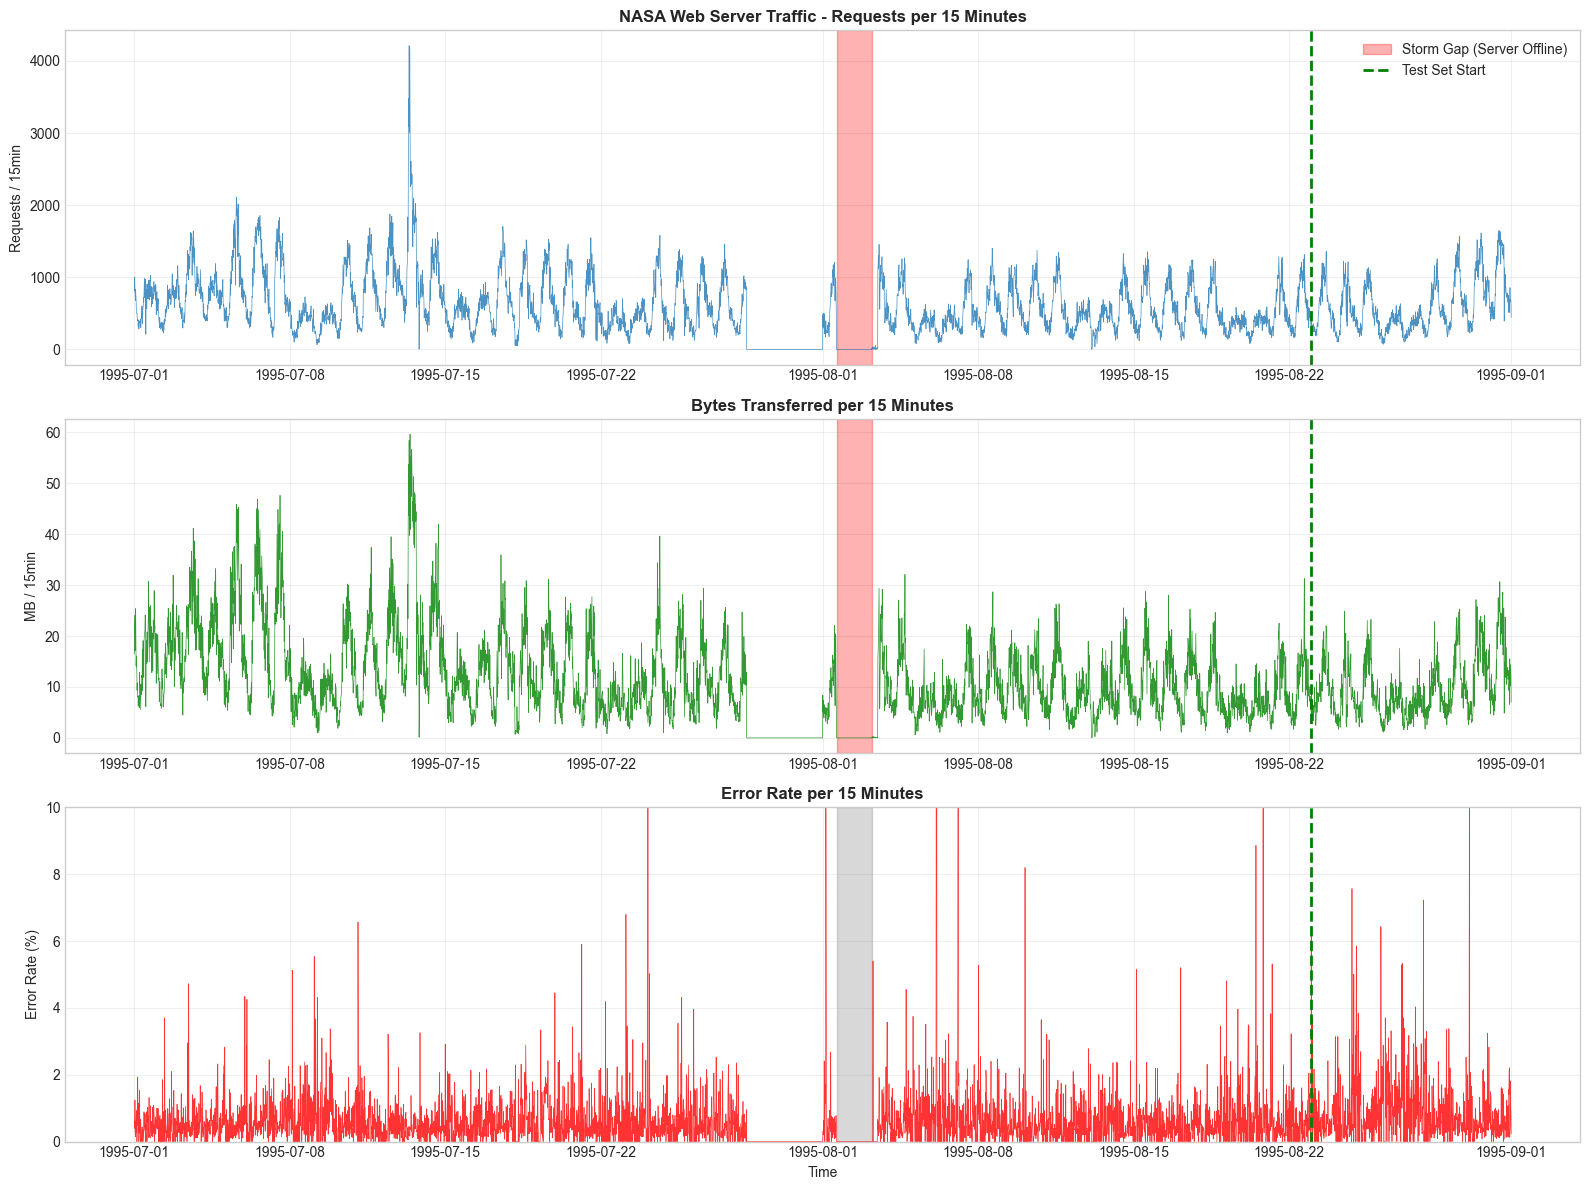

In [7]:
# Storm period
STORM_START = pd.Timestamp('1995-08-01 14:52:01')
STORM_END = pd.Timestamp('1995-08-03 04:36:13')

# Plot traffic over time
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Requests per 15-min
ax1 = axes[0]
ax1.plot(df.index, df['request_count'], linewidth=0.5, alpha=0.8)
ax1.axvspan(STORM_START, STORM_END, alpha=0.3, color='red', label='Storm Gap (Server Offline)')
ax1.axvline(pd.Timestamp('1995-08-23'), color='green', linestyle='--', linewidth=2, label='Test Set Start')
ax1.set_ylabel('Requests / 15min')
ax1.set_title('NASA Web Server Traffic - Requests per 15 Minutes', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Bytes per 15-min
ax2 = axes[1]
ax2.plot(df.index, df['bytes_total'] / 1e6, linewidth=0.5, alpha=0.8, color='green')
ax2.axvspan(STORM_START, STORM_END, alpha=0.3, color='red')
ax2.axvline(pd.Timestamp('1995-08-23'), color='green', linestyle='--', linewidth=2)
ax2.set_ylabel('MB / 15min')
ax2.set_title('Bytes Transferred per 15 Minutes', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Error rate
ax3 = axes[2]
ax3.plot(df.index, df['error_rate'] * 100, linewidth=0.5, alpha=0.8, color='red')
ax3.axvspan(STORM_START, STORM_END, alpha=0.3, color='gray')
ax3.axvline(pd.Timestamp('1995-08-23'), color='green', linestyle='--', linewidth=2)
ax3.set_ylabel('Error Rate (%)')
ax3.set_xlabel('Time')
ax3.set_title('Error Rate per 15 Minutes', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 10)  # Limit để dễ nhìn
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/traffic_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Hourly Traffic Pattern

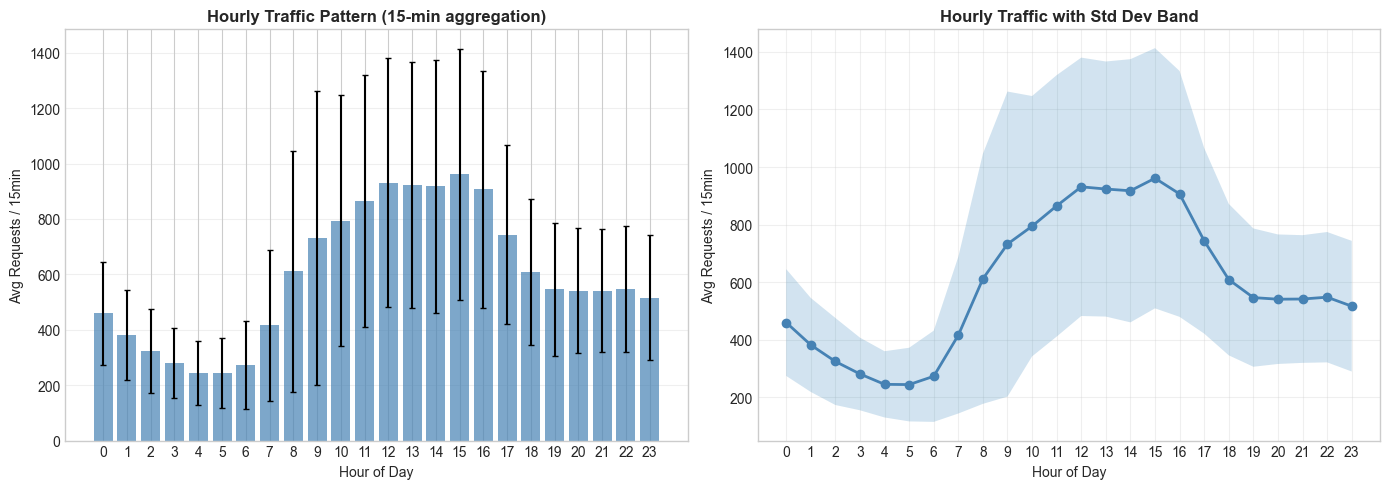


Peak hours (top 5):
        req_mean     req_std
hour                        
15    961.083333  452.202626
12    931.262295  449.041710
13    923.557377  443.291691
14    917.500000  457.355428
16    906.512500  427.253229

Lowest traffic hours (bottom 5):
        req_mean     req_std
hour                        
5     243.872951  127.969021
4     244.705394  115.117695
6     272.704918  158.508931
3     280.804167  126.209459
2     324.187500  151.268729


In [8]:
# Hourly pattern (loại bỏ storm period)
df_clean = df[df['is_storm_period'] == 0]

hourly_pattern = df_clean.groupby('hour').agg({
    'request_count': ['mean', 'std', 'median', 'max'],
    'bytes_total': 'mean',
    'error_rate': 'mean'
})

hourly_pattern.columns = ['req_mean', 'req_std', 'req_median', 'req_max', 'bytes_mean', 'error_rate_mean']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart với error bars
ax1 = axes[0]
ax1.bar(hourly_pattern.index, hourly_pattern['req_mean'], 
        yerr=hourly_pattern['req_std'], capsize=2, alpha=0.7, color='steelblue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Requests / 15min')
ax1.set_title('Hourly Traffic Pattern (15-min aggregation)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(24))
ax1.grid(True, alpha=0.3, axis='y')

# Line chart với confidence band
ax2 = axes[1]
ax2.plot(hourly_pattern.index, hourly_pattern['req_mean'], 'o-', linewidth=2, markersize=6, color='steelblue')
ax2.fill_between(hourly_pattern.index, 
                 hourly_pattern['req_mean'] - hourly_pattern['req_std'],
                 hourly_pattern['req_mean'] + hourly_pattern['req_std'],
                 alpha=0.2)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Avg Requests / 15min')
ax2.set_title('Hourly Traffic with Std Dev Band', fontsize=12, fontweight='bold')
ax2.set_xticks(range(24))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/hourly_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPeak hours (top 5):")
print(hourly_pattern.nlargest(5, 'req_mean')[['req_mean', 'req_std']])

print("\nLowest traffic hours (bottom 5):")
print(hourly_pattern.nsmallest(5, 'req_mean')[['req_mean', 'req_std']])

## 5. Day of Week Pattern

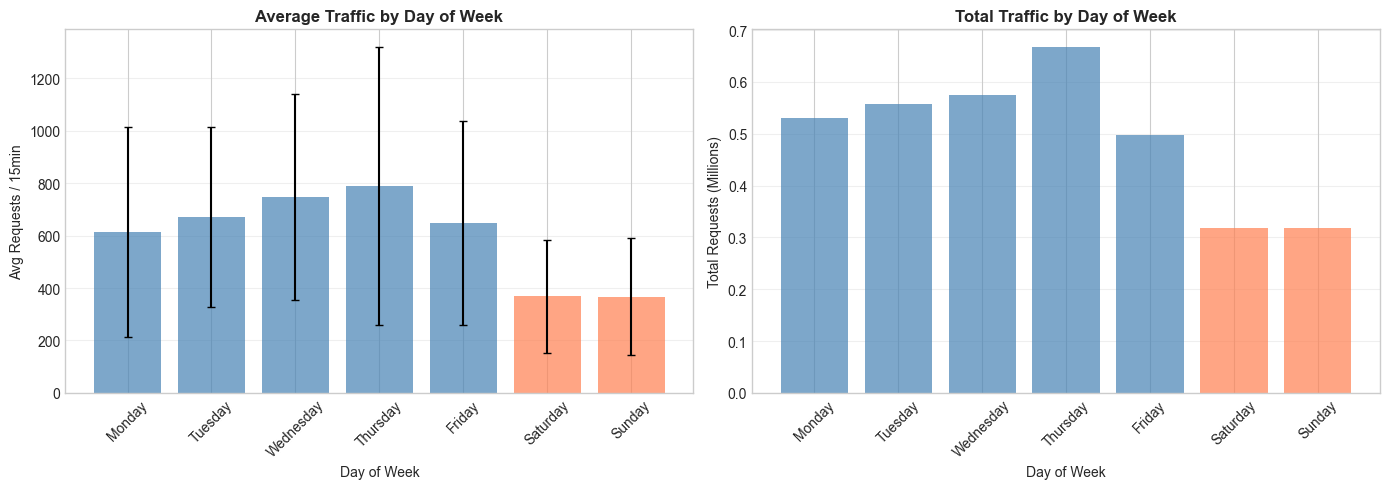

Day of Week Statistics:
             req_mean     req_std  req_total  bytes_total
day_name                                                 
Monday     613.372685  401.393223     529954   9911954542
Tuesday    672.208937  343.156588     556589  10137952128
Wednesday  748.106771  393.529586     574546  10385240509
Thursday   790.192899  530.813827     667713  12229562735
Friday     647.729167  388.052534     497456   9583254434
Saturday   368.107639  216.016300     318045   6666229981
Sunday     367.217593  223.383663     317276   6610038555


In [9]:
# Day of week pattern
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_pattern = df_clean.groupby('day_name').agg({
    'request_count': ['mean', 'std', 'sum'],
    'bytes_total': 'sum'
})
dow_pattern.columns = ['req_mean', 'req_std', 'req_total', 'bytes_total']
dow_pattern = dow_pattern.reindex(dow_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avg requests by day
ax1 = axes[0]
colors = ['steelblue'] * 5 + ['coral'] * 2  # Weekday vs Weekend
ax1.bar(dow_pattern.index, dow_pattern['req_mean'], 
        yerr=dow_pattern['req_std'], capsize=3, color=colors, alpha=0.7)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Avg Requests / 15min')
ax1.set_title('Average Traffic by Day of Week', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Total requests by day
ax2 = axes[1]
ax2.bar(dow_pattern.index, dow_pattern['req_total'] / 1e6, color=colors, alpha=0.7)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Total Requests (Millions)')
ax2.set_title('Total Traffic by Day of Week', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/dow_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

print("Day of Week Statistics:")
print(dow_pattern)

## 6. Traffic Heatmap (Hour x Day)

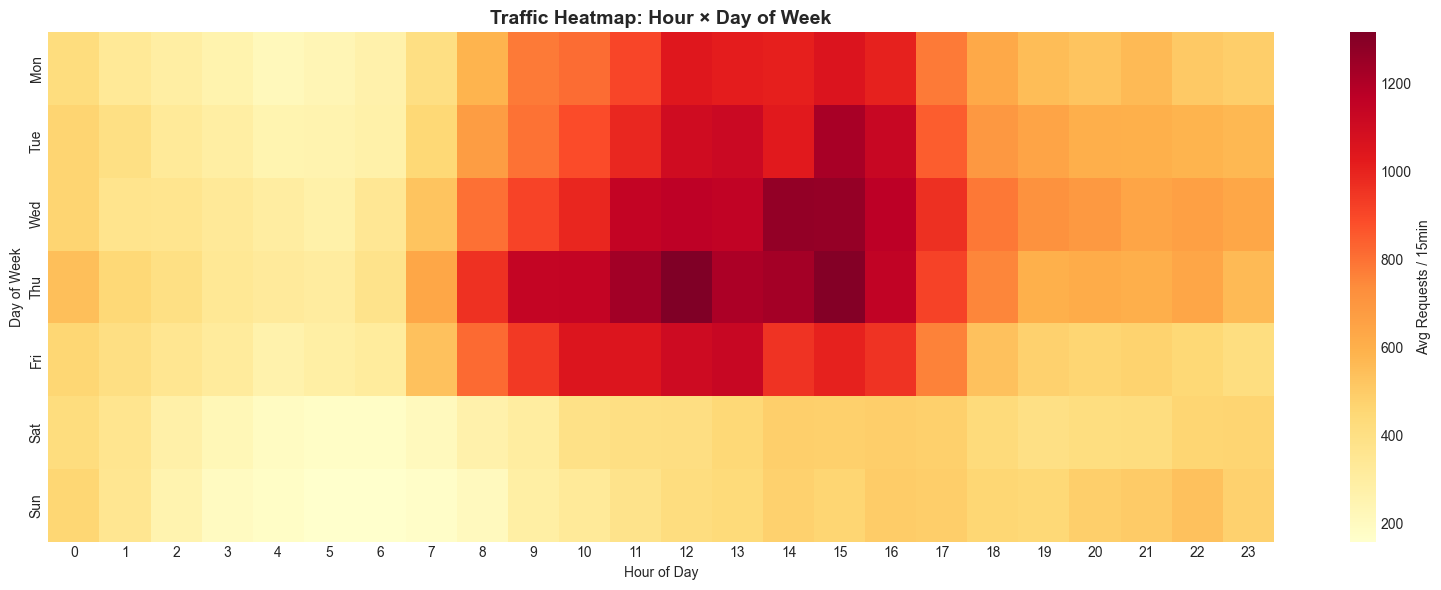

In [10]:
# Tạo heatmap
heatmap_data = df_clean.groupby(['day_of_week', 'hour'])['request_count'].mean().unstack()

# Đổi tên rows
heatmap_data.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, 
            xticklabels=range(24), yticklabels=heatmap_data.index,
            cbar_kws={'label': 'Avg Requests / 15min'})
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Traffic Heatmap: Hour × Day of Week', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/traffic_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Daily Traffic Trends

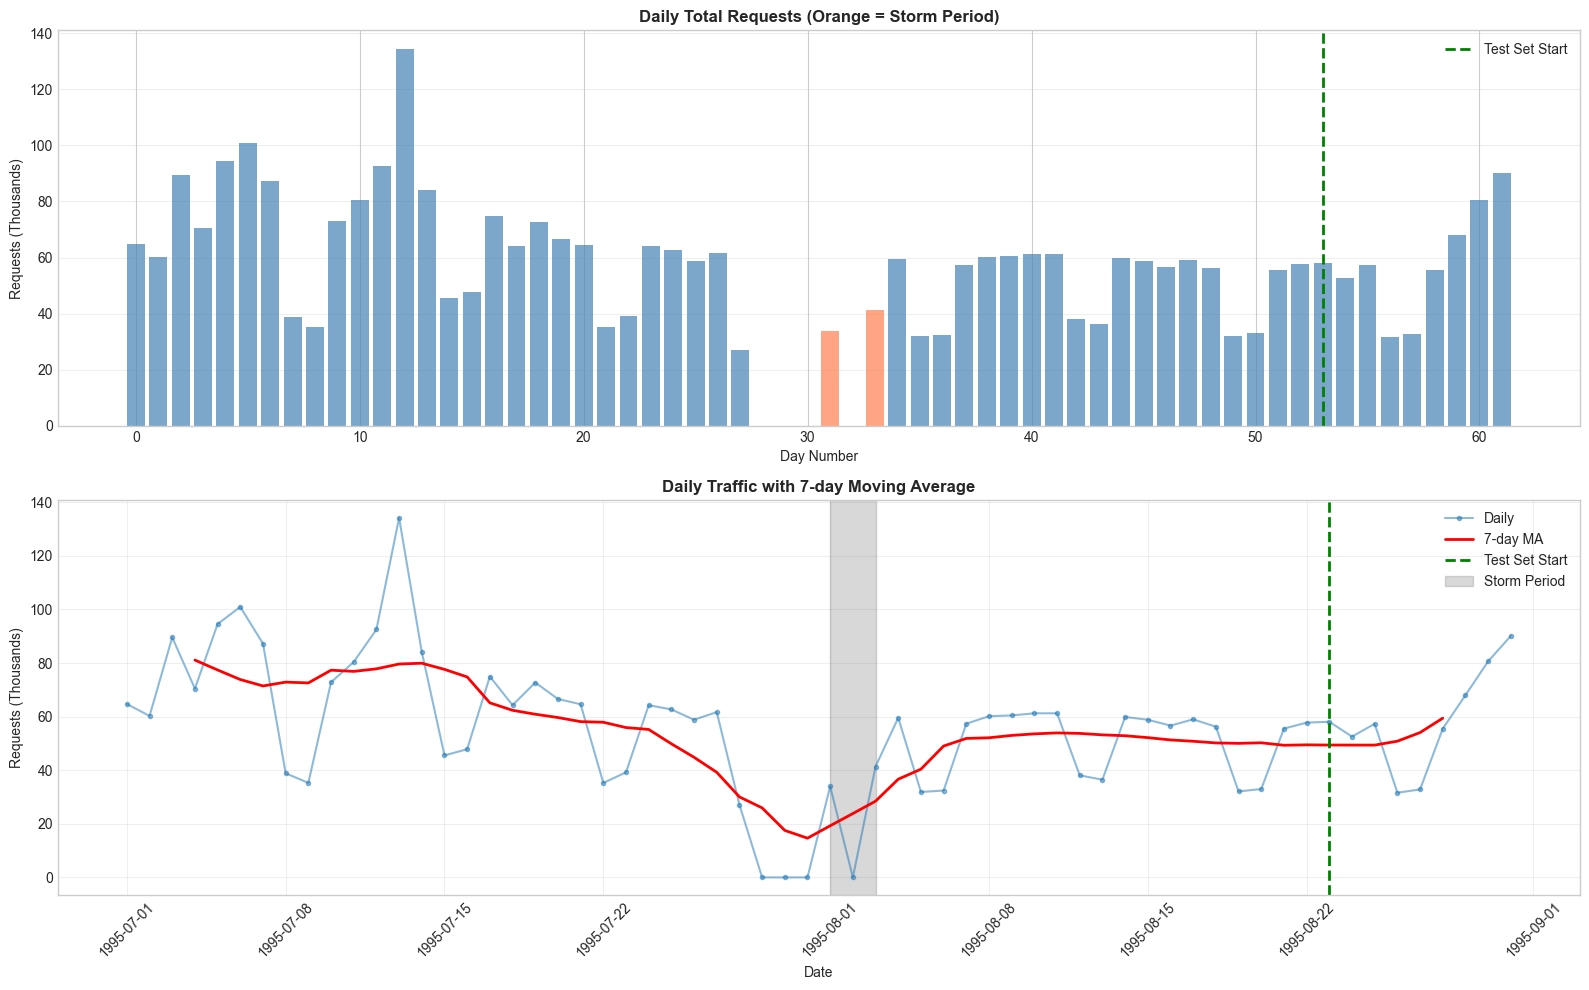

In [11]:
# Daily totals
daily = df.groupby('date').agg({
    'request_count': 'sum',
    'bytes_total': 'sum',
    'error_count': 'sum',
    'is_storm_period': 'sum'
})
daily['error_rate'] = daily['error_count'] / daily['request_count'].replace(0, np.nan)
daily['is_storm_day'] = daily['is_storm_period'] > 0

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily requests
ax1 = axes[0]
colors = ['coral' if x else 'steelblue' for x in daily['is_storm_day']]
ax1.bar(range(len(daily)), daily['request_count'] / 1e3, color=colors, alpha=0.7)
ax1.axvline(len(daily[daily.index < pd.Timestamp('1995-08-23').date()]), 
            color='green', linestyle='--', linewidth=2, label='Test Set Start')
ax1.set_xlabel('Day Number')
ax1.set_ylabel('Requests (Thousands)')
ax1.set_title('Daily Total Requests (Orange = Storm Period)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Daily trend with moving average
ax2 = axes[1]
ax2.plot(daily.index, daily['request_count'] / 1e3, 'o-', alpha=0.5, markersize=3, label='Daily')
ax2.plot(daily.index, daily['request_count'].rolling(7, center=True).mean() / 1e3, 
         linewidth=2, color='red', label='7-day MA')
ax2.axvline(pd.Timestamp('1995-08-23').date(), color='green', linestyle='--', linewidth=2, label='Test Set Start')
ax2.axvspan(STORM_START.date(), STORM_END.date(), alpha=0.3, color='gray', label='Storm Period')
ax2.set_xlabel('Date')
ax2.set_ylabel('Requests (Thousands)')
ax2.set_title('Daily Traffic with 7-day Moving Average', fontsize=12, fontweight='bold')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/daily_trends.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Storm Gap Analysis

In [12]:
# Phân tích storm period
print("="*60)
print("STORM GAP ANALYSIS")
print("="*60)
print(f"\nStorm period: {STORM_START} to {STORM_END}")
print(f"Duration: {(STORM_END - STORM_START).total_seconds() / 3600:.1f} hours")

# Traffic ngay trước và sau storm
pre_storm = df[(df.index >= STORM_START - pd.Timedelta(hours=6)) & (df.index < STORM_START)]
post_storm = df[(df.index > STORM_END) & (df.index <= STORM_END + pd.Timedelta(hours=6))]

print(f"\nTraffic 6 giờ TRƯỚC storm:")
print(f"  Avg requests/15min: {pre_storm['request_count'].mean():.1f}")
print(f"  Total requests: {pre_storm['request_count'].sum():,}")

print(f"\nTraffic 6 giờ SAU storm:")
print(f"  Avg requests/15min: {post_storm['request_count'].mean():.1f}")
print(f"  Total requests: {post_storm['request_count'].sum():,}")

# Missing windows trong storm
storm_windows = df[(df.index >= STORM_START) & (df.index <= STORM_END)]
print(f"\nSố windows trong storm period: {len(storm_windows)}")
print(f"Số windows với traffic = 0: {(storm_windows['request_count'] == 0).sum()}")

STORM GAP ANALYSIS

Storm period: 1995-08-01 14:52:01 to 1995-08-03 04:36:13
Duration: 37.7 hours

Traffic 6 giờ TRƯỚC storm:
  Avg requests/15min: 873.7
  Total requests: 20,968

Traffic 6 giờ SAU storm:
  Avg requests/15min: 14.2
  Total requests: 340

Số windows trong storm period: 151
Số windows với traffic = 0: 150


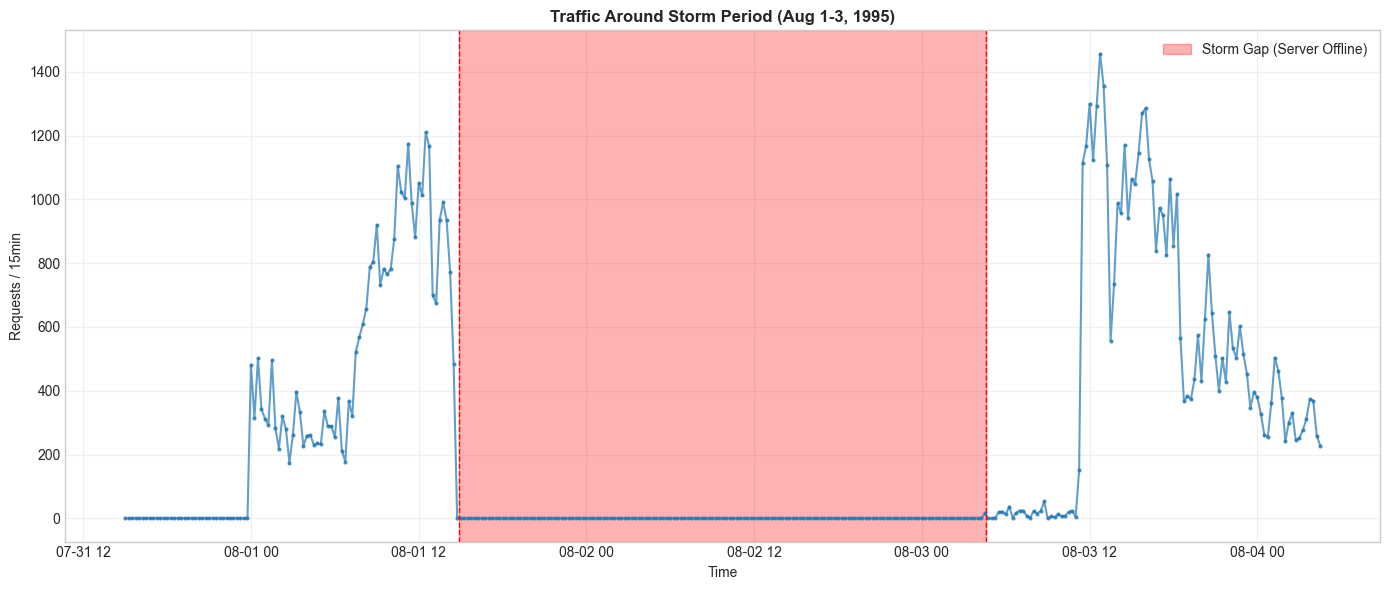

In [13]:
# Zoom vào storm period
storm_range = df[(df.index >= STORM_START - pd.Timedelta(hours=24)) & 
                 (df.index <= STORM_END + pd.Timedelta(hours=24))]

plt.figure(figsize=(14, 6))
plt.plot(storm_range.index, storm_range['request_count'], 'o-', markersize=2, alpha=0.7)
plt.axvspan(STORM_START, STORM_END, alpha=0.3, color='red', label='Storm Gap (Server Offline)')
plt.axvline(STORM_START, color='red', linestyle='--', linewidth=1)
plt.axvline(STORM_END, color='red', linestyle='--', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Requests / 15min')
plt.title('Traffic Around Storm Period (Aug 1-3, 1995)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/storm_gap.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Distribution Analysis

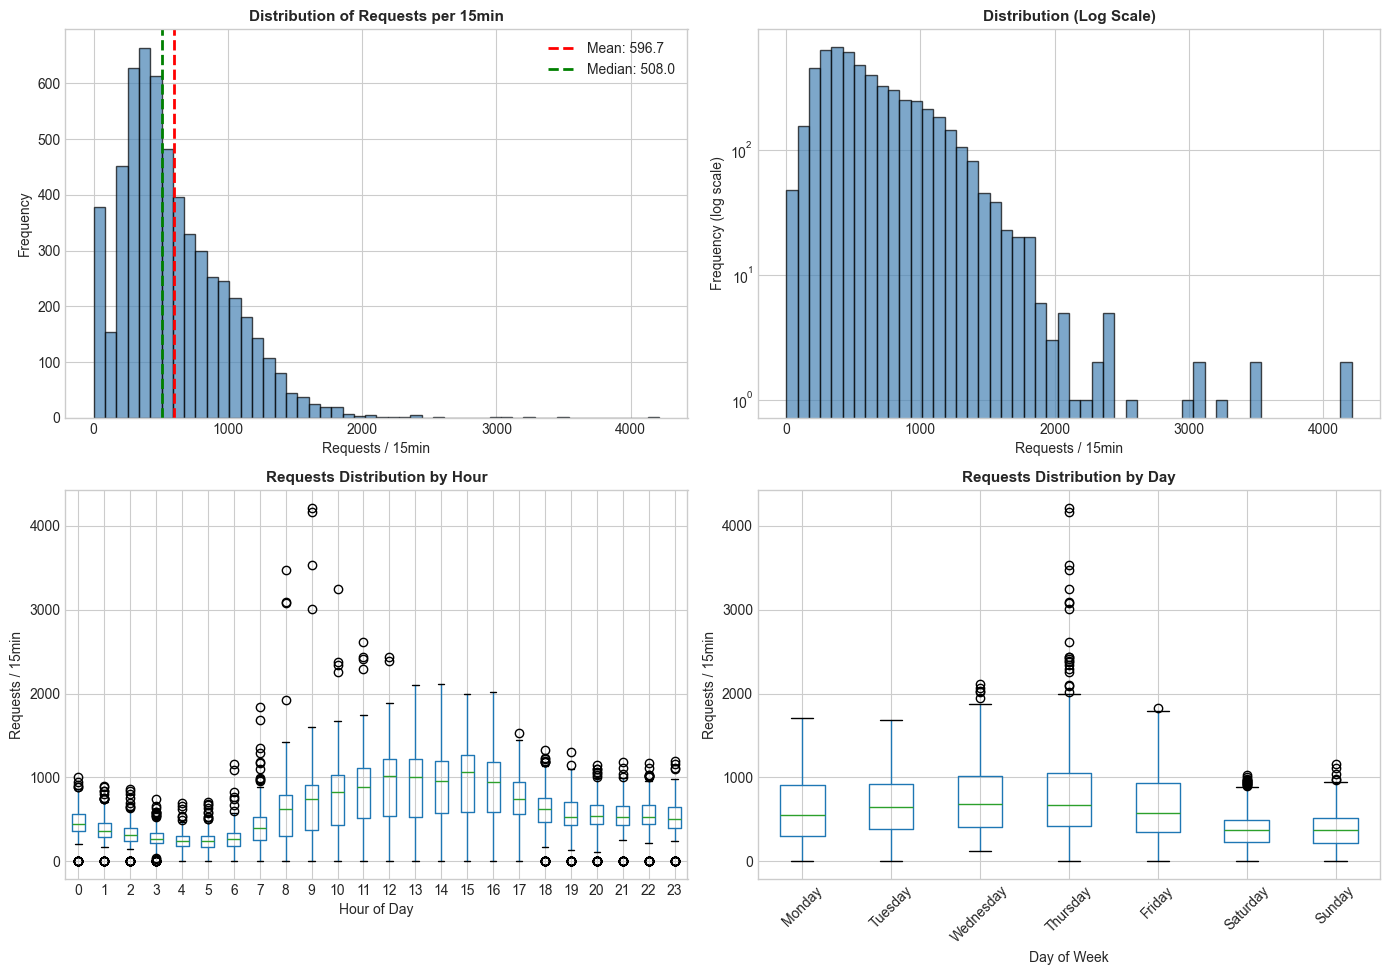

In [14]:
# Distribution của requests (loại bỏ storm period)
requests_clean = df_clean['request_count']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
ax1 = axes[0, 0]
ax1.hist(requests_clean, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(requests_clean.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {requests_clean.mean():.1f}')
ax1.axvline(requests_clean.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {requests_clean.median():.1f}')
ax1.set_xlabel('Requests / 15min')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Requests per 15min', fontsize=11, fontweight='bold')
ax1.legend()

# Log histogram
ax2 = axes[0, 1]
ax2.hist(requests_clean[requests_clean > 0], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.set_yscale('log')
ax2.set_xlabel('Requests / 15min')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_title('Distribution (Log Scale)', fontsize=11, fontweight='bold')

# Boxplot by hour
ax3 = axes[1, 0]
df_clean.boxplot(column='request_count', by='hour', ax=ax3)
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Requests / 15min')
ax3.set_title('Requests Distribution by Hour', fontsize=11, fontweight='bold')
plt.suptitle('')  # Remove auto title

# Boxplot by day of week
ax4 = axes[1, 1]
df_clean_ordered = df_clean.copy()
df_clean_ordered['day_name'] = pd.Categorical(df_clean_ordered['day_name'], 
                                               categories=dow_order, ordered=True)
df_clean_ordered.boxplot(column='request_count', by='day_name', ax=ax4)
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Requests / 15min')
ax4.set_title('Requests Distribution by Day', fontsize=11, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.savefig('../reports/figures/distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Autocorrelation Analysis

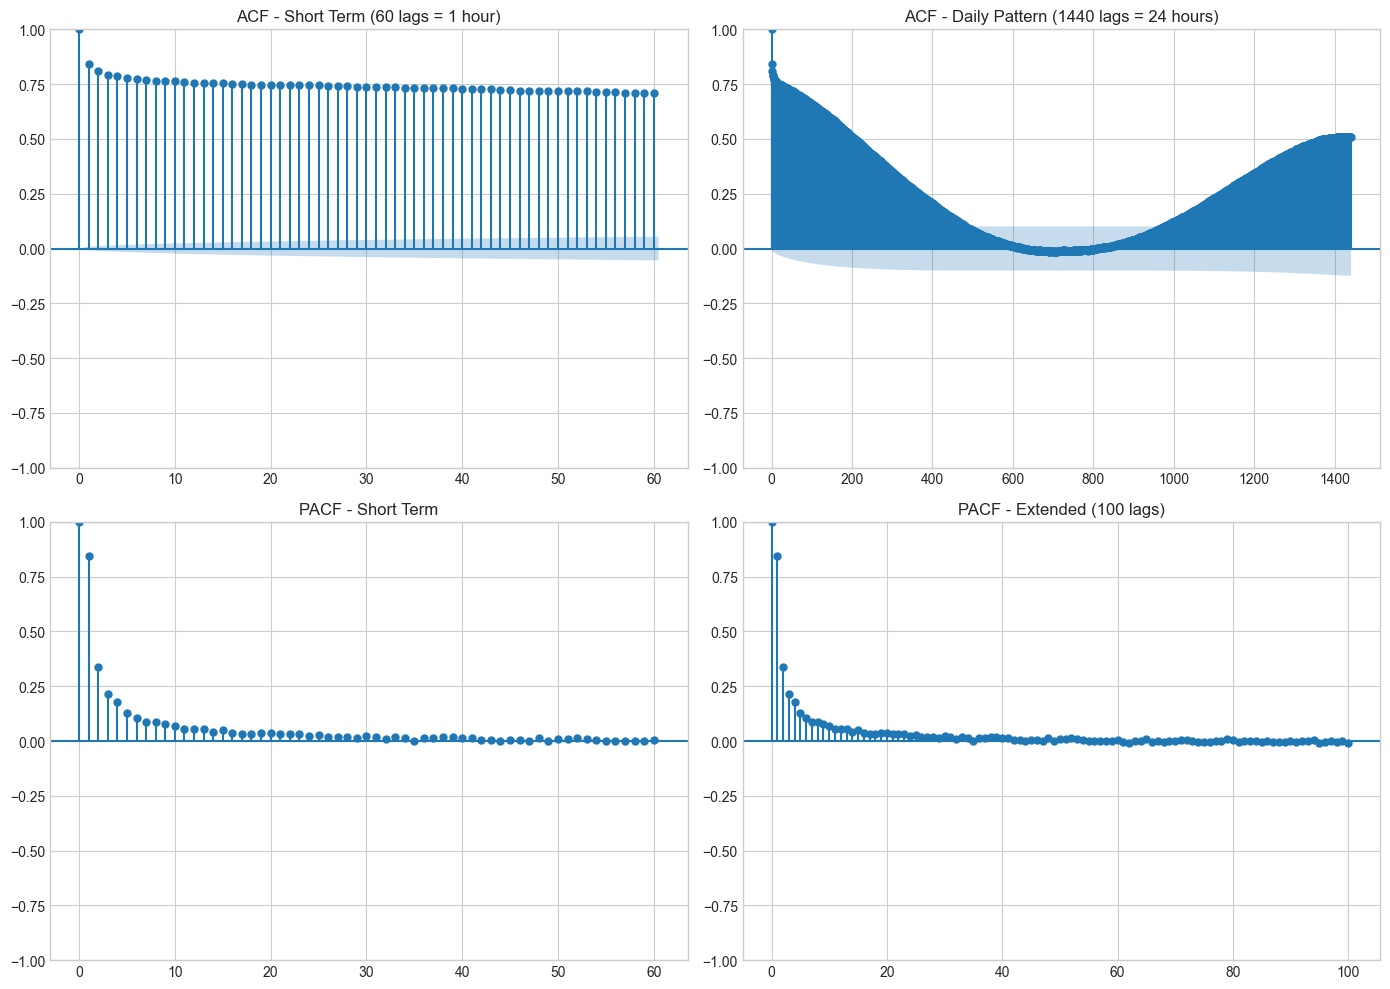


Insights từ ACF/PACF:
- Strong autocorrelation ở các lags gần (consecutive minutes)
- Seasonality rõ ràng ở lag 60 (hourly) và lag 1440 (daily)
- PACF suggests AR components significant


In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Dùng 1-min data cho ACF analysis
ts_clean = ts_1min[ts_1min['is_storm_period'] == 0]['request_count']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF - short term
ax1 = axes[0, 0]
plot_acf(ts_clean.dropna(), lags=60, ax=ax1, title='ACF - Short Term (60 lags = 1 hour)')

# ACF - long term (daily pattern)
ax2 = axes[0, 1]
plot_acf(ts_clean.dropna(), lags=1440, ax=ax2, title='ACF - Daily Pattern (1440 lags = 24 hours)')

# PACF - short term
ax3 = axes[1, 0]
plot_pacf(ts_clean.dropna(), lags=60, ax=ax3, method='ywm', title='PACF - Short Term')

# PACF - long term
ax4 = axes[1, 1]
# Limit lags cho PACF để tránh computational issues
plot_pacf(ts_clean.dropna(), lags=100, ax=ax4, method='ywm', title='PACF - Extended (100 lags)')

plt.tight_layout()
plt.savefig('../reports/figures/acf_pacf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInsights từ ACF/PACF:")
print("- Strong autocorrelation ở các lags gần (consecutive minutes)")
print("- Seasonality rõ ràng ở lag 60 (hourly) và lag 1440 (daily)")
print("- PACF suggests AR components significant")

## 11. Train vs Test Comparison

In [16]:
# Split train/test
train_ts, test_ts = split_train_test(ts_15min, test_start='1995-08-23')

# Loại bỏ storm period khỏi train
train_clean = train_ts[train_ts['is_storm_period'] == 0]

print("="*60)
print("TRAIN vs TEST COMPARISON")
print("="*60)

print(f"\nTrain Set (excluding storm):")
print(f"  Records: {len(train_clean):,}")
print(f"  Date range: {train_clean.index.min()} to {train_clean.index.max()}")
print(f"  Avg requests/15min: {train_clean['request_count'].mean():.1f}")
print(f"  Std: {train_clean['request_count'].std():.1f}")

print(f"\nTest Set:")
print(f"  Records: {len(test_ts):,}")
print(f"  Date range: {test_ts.index.min()} to {test_ts.index.max()}")
print(f"  Avg requests/15min: {test_ts['request_count'].mean():.1f}")
print(f"  Std: {test_ts['request_count'].std():.1f}")

TRAIN vs TEST COMPARISON

Train Set (excluding storm):
  Records: 4,937
  Date range: 1995-07-01 00:00:00 to 1995-08-22 23:45:00
  Avg requests/15min: 594.5
  Std: 409.8

Test Set:
  Records: 864
  Date range: 1995-08-23 00:00:00 to 1995-08-31 23:45:00
  Avg requests/15min: 609.5
  Std: 356.1


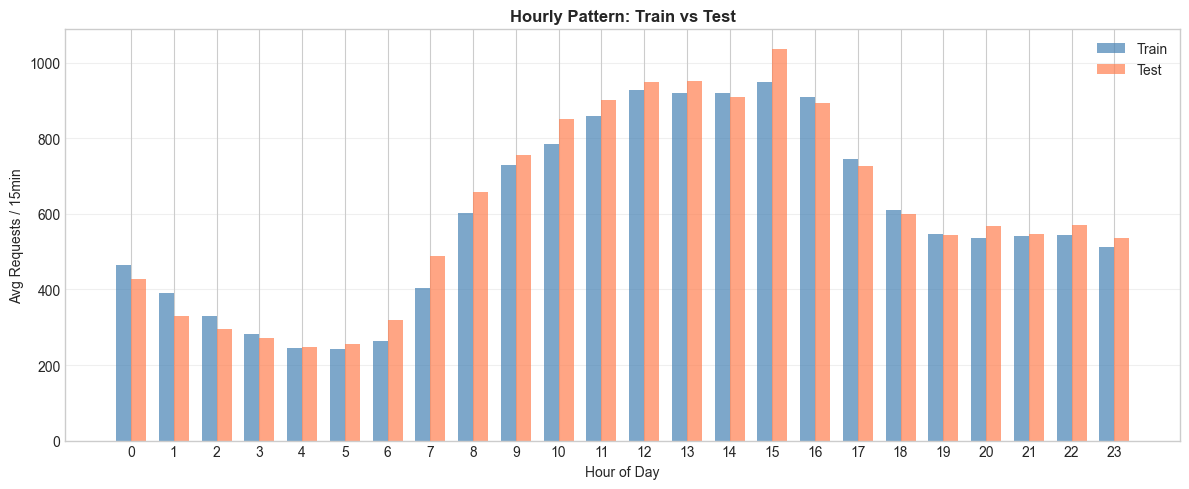


Correlation giữa train và test hourly patterns: 0.9894


In [17]:
# So sánh hourly patterns
train_hourly = train_clean.groupby(train_clean.index.hour)['request_count'].mean()
test_hourly = test_ts.groupby(test_ts.index.hour)['request_count'].mean()

fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(24)
width = 0.35

ax.bar(x - width/2, train_hourly, width, label='Train', alpha=0.7, color='steelblue')
ax.bar(x + width/2, test_hourly, width, label='Test', alpha=0.7, color='coral')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Avg Requests / 15min')
ax.set_title('Hourly Pattern: Train vs Test', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/train_test_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation giữa train và test patterns
correlation = np.corrcoef(train_hourly, test_hourly)[0, 1]
print(f"\nCorrelation giữa train và test hourly patterns: {correlation:.4f}")

## 12. Key Insights Summary

In [18]:
print("="*70)
print("                        KEY INSIGHTS SUMMARY")
print("="*70)

print("""
1. TRAFFIC PATTERNS:
   - Rõ ràng có DAILY SEASONALITY (24-hour cycle)
   - Peak hours: 10:00-16:00 (business hours, US Eastern Time)
   - Low traffic: 03:00-07:00 (night time)
   - Weekdays có traffic cao hơn Weekend ~20%

2. STORM GAP:
   - Server offline: 01/Aug 14:52 → 03/Aug 04:36 (~38 giờ)
   - Đây là missing data thực sự, KHÔNG phải low traffic
   - Cần xử lý đặc biệt khi training models

3. STATISTICS:
   - Avg requests/15min: ~{:.1f}
   - Max requests/15min: {:,}
   - Error rate trung bình: ~0.5%
   - Data highly autocorrelated (lag-1 correlation rất cao)

4. TRAIN/TEST SPLIT:
   - Train: Jul 1 - Aug 22 (bao gồm storm gap)
   - Test: Aug 23-31 (9 ngày cuối)
   - Hourly patterns tương đồng (correlation: {:.4f})

5. MODELING IMPLICATIONS:
   - Cần capture hourly seasonality (m=60 cho 1-min, m=4 cho 15-min)
   - Daily seasonality cũng quan trọng (m=1440 cho 1-min, m=96 cho 15-min)
   - SARIMA nên dùng seasonal order với m phù hợp
   - LightGBM cần features: hour, day_of_week, lag features
""".format(
    df_clean['request_count'].mean(),
    int(df_clean['request_count'].max()),
    correlation
))

                        KEY INSIGHTS SUMMARY

1. TRAFFIC PATTERNS:
   - Rõ ràng có DAILY SEASONALITY (24-hour cycle)
   - Peak hours: 10:00-16:00 (business hours, US Eastern Time)
   - Low traffic: 03:00-07:00 (night time)
   - Weekdays có traffic cao hơn Weekend ~20%

2. STORM GAP:
   - Server offline: 01/Aug 14:52 → 03/Aug 04:36 (~38 giờ)
   - Đây là missing data thực sự, KHÔNG phải low traffic
   - Cần xử lý đặc biệt khi training models

3. STATISTICS:
   - Avg requests/15min: ~596.7
   - Max requests/15min: 4,212
   - Error rate trung bình: ~0.5%
   - Data highly autocorrelated (lag-1 correlation rất cao)

4. TRAIN/TEST SPLIT:
   - Train: Jul 1 - Aug 22 (bao gồm storm gap)
   - Test: Aug 23-31 (9 ngày cuối)
   - Hourly patterns tương đồng (correlation: 0.9894)

5. MODELING IMPLICATIONS:
   - Cần capture hourly seasonality (m=60 cho 1-min, m=4 cho 15-min)
   - Daily seasonality cũng quan trọng (m=1440 cho 1-min, m=96 cho 15-min)
   - SARIMA nên dùng seasonal order với m phù hợp
   -

## Summary

### Kết quả EDA:
1. **Seasonality rõ ràng**: Daily (24h) và Weekly patterns
2. **Storm gap cần xử lý**: ~38 giờ server offline
3. **Train/Test patterns tương đồng**: Correlation cao
4. **High autocorrelation**: Cần lag features cho ML models

### Figures đã tạo:
- `traffic_timeline.png`: Traffic over time
- `hourly_pattern.png`: Hourly patterns
- `dow_pattern.png`: Day of week patterns
- `traffic_heatmap.png`: Hour × Day heatmap
- `daily_trends.png`: Daily trends với MA
- `storm_gap.png`: Storm period zoom
- `distributions.png`: Distribution analysis
- `acf_pacf.png`: Autocorrelation analysis
- `train_test_comparison.png`: Train vs Test

### Next Steps:
- Notebook 03: Feature Engineering
- Notebook 04-06: Model Training (SARIMA, LightGBM, Prophet)